In [17]:
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rasterio.mask import mask
from sklearn.preprocessing import StandardScaler
import faiss
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from scipy import ndimage

In [18]:
def remove_outliers(df, column_name):
    '''
    Removes the outliers found in each column of a given dataframe and deletes the rows
    containing them using Z-score method.

    Parameters
    ----------
        df: dataframe. Dataframe containing the values of the feature space, along with the labels of each class
        column_name: string. Name of the column containing the values of the feature space
    '''
    # Get the values of the feature space
    mean = df[column_name].mean()
    std = df[column_name].std()
    threshold = 3 # any point outside this range will be considered an outlier

    # Calculate Z-score
    z_score = (df[column_name] - mean) / std

    # Keep only values within threshold range
    df = df[abs(z_score) <= threshold]

    return df

In [19]:
def calculate_vi(img):
    '''
    Calculates ancillary remote-sensing vegetation indices.

    Parameters
    ----------
    img: np.array . Multi-dimensional numpy array in format (height, width, n_channels)
    '''
    blue_band = img[...,0]
    green_band = img[...,1]
    red_band = img[...,2]
    nir_band = img[...,6]

    #Caclulate Normalized Difference Vegetation Index (NDVI)
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    #Optimized Soil Adjusted Vegetation Index (OSAVI)
    osavi = (nir_band - red_band) / (nir_band + red_band + 0.16)
    #Soil Adjusted Vegetation Index (SAVI)
    savi = 1.5*(nir_band - red_band) / (nir_band + red_band + 0.5)
    #Calculate GNDVI
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    #Calculate NDWI
    ndwi = (green_band - nir_band) / (green_band + nir_band)
    #Enhanced Vegetation Index (EVI)
    evi = 2.5 * ((nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1))
    #Modified Soil Adjusted Vegetation Index (MSAVI)
    msavi = 0.5 * (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)^2 - 8 * (nir_band - red_band)))
    #Leaf Area Index (LAI)
    lai = -np.log(0.69 - 0.59 * np.exp(-0.91 * ndvi))

    #Stack values
    vis = np.stack((ndvi, osavi, savi, gndvi, ndwi, evi, lai),axis=2)
    vis = np.nan_to_num(vis, nan=0)
    
    return vis

In [20]:
def extract_values(raster, gdf):
    '''
    This function clips the geometry of a vector file to a desired raster,
    to get the values of the raster that falls within the vector's geometry.
    
    Parameters
    ----------
        raster: str. Path to the tif.
        gdf: GeoDataFrame. Geodataframe that contains the geometries of the polygons
    '''
    
    # Clip vector on rasters to extract values
    colnames = ["B02" ,"B03", "B04", "B05", "B06", "B07", 
                "B08", "B09", "B11", "B12", "B8A", "ndvi", 
                "osavi", "savi", "gndvi", "ndwi", "evi", 
                "lai", "label"] 
    
    lsdf = list()
    with rasterio.open(raster) as src:
        for m in range(gdf.shape[0]):
            shape, classid = gdf.geometry.iloc[m], gdf.label.iloc[m]
            out_image, out_transform = mask(src,shape,crop=True)
            img = np.moveaxis(out_image, 0, -1) #img
            vis = calculate_vi(img) #vis
            fs = np.concatenate((img, vis), axis=2)
            fs = fs.reshape(-1, fs.shape[2])
            fs = fs[~np.all(fs == 0, axis=1)]
            df = pd.concat([pd.DataFrame(fs), pd.DataFrame([classid]*(fs.shape[0]))], axis=1)
            df.columns = colnames
            lsdf.append(df)
    ndf = pd.concat(lsdf).reset_index(drop=True)
            
    return ndf

In [ ]:
def scale_data(df):
    '''
    Scales the data using the StandardScaler.

    Parameters
    ----------
        df (pandas.DataFrame): DataFrame with values and label columns.

    '''
    
    # QuantileTransformer, RobustScaler, MaxAbsScaler, Normalizer, PowerTransformer, MinMaxScaler 
    scaler = StandardScaler()
    unique_labels = df['label'].unique()
    for label in unique_labels:
        values = df.loc[df['label'] == label].iloc[:, :-1].values
        sc_values = scaler.fit_transform(values)
        df.loc[df.label == label, df.columns[:-1]] = sc_values

    return df

In [21]:
def perform_pca(df):
    '''
    Performs Principal Component Analysis (PCA) on the input data.

    Parameters
    ----------
        df (pandas.DataFrame): DataFrame with values and label columns.
    '''
    
    data, labels = df.iloc[:,:-1].values, df.iloc[:,-1].values
    pca = faiss.PCAMatrix(data.shape[1], 3)
    data = data.astype(np.float32)
    data = np.ascontiguousarray(data)
    pca.train(data)
    principalComponents = pca.apply(data)

    #Visualize results
    dfn = df.copy()
    dfn['pca-one'] = principalComponents[:,0]
    dfn['pca-two'] = principalComponents[:,1] 
    dfn['pca-three'] = principalComponents[:,2]
    
    return dfn, principalComponents

In [22]:
def oversample_data(df):
    """
    Oversamples the data using SMOTE algorithm.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with 3 columns of values and 1 column of label.
    """

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    #Define the SMOTE algorithm with "auto" sampling strategy
    smote = SMOTE(sampling_strategy="auto")
    #Oversample the data
    X_res, y_res = smote.fit_resample(X, y)
    X_res = X_res.astype(np.float32)
    #Combine X_res and y_res arrays into a single numpy array
    resampled_data = np.column_stack((X_res, y_res))
    #Shuffle the resampled data to ensure that the order of rows is random
    np.random.shuffle(resampled_data)

    return resampled_data

In [23]:
#Set up the paths to import raster data
path2rasters = "./path2training"
imglist = [str(x) for x in Path(path2rasters).glob("*") if x.is_file()]
imglist.sort()
path2vector = "./training_polygons.geojson"
gdf = gpd.read_file(path2vector)

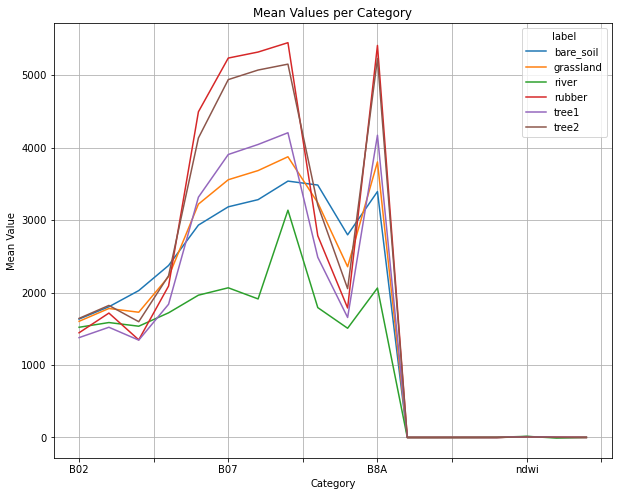

In [29]:
ls = [extract_values(raster, gdf) for raster in imglist]

# #Genereate the feature space
df = pd.concat(ls).reset_index(drop=True)
max_value_index = df['evi'].idxmax()
df = df.drop(max_value_index)

# #Remove outliers from the dataset
for col in df.columns[:-1]:
    df = remove_outliers(df, col)
df = df.reset_index(drop=True)

grouped_df = df.groupby('label').mean().T
grouped_df.plot(figsize=(10,8))
plt.grid()
plt.title('Mean Values per Category')
plt.xlabel('Category')
plt.ylabel('Mean Value')
plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 31620 samples in 0.000s...
[t-SNE] Computed neighbors for 31620 samples in 15.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31620
[t-SNE] Computed conditional probabilities for sample 2000 / 31620
[t-SNE] Computed conditional probabilities for sample 3000 / 31620
[t-SNE] Computed conditional probabilities for sample 4000 / 31620
[t-SNE] Computed conditional probabilities for sample 5000 / 31620
[t-SNE] Computed conditional probabilities for sample 6000 / 31620
[t-SNE] Computed conditional probabilities for sample 7000 / 31620
[t-SNE] Computed conditional probabilities for sample 8000 / 31620
[t-SNE] Computed conditional probabilities for sample 9000 / 31620
[t-SNE] Computed conditional probabilities for sample 10000 / 31620
[t-SNE] Computed conditional probabilities for sample 11000 / 31620
[t-SNE] Computed conditional probabilities for sample 12000 / 31620
[t-SNE] Computed conditional probabilities for sa

<AxesSubplot:title={'center':'t-SNE results'}, xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

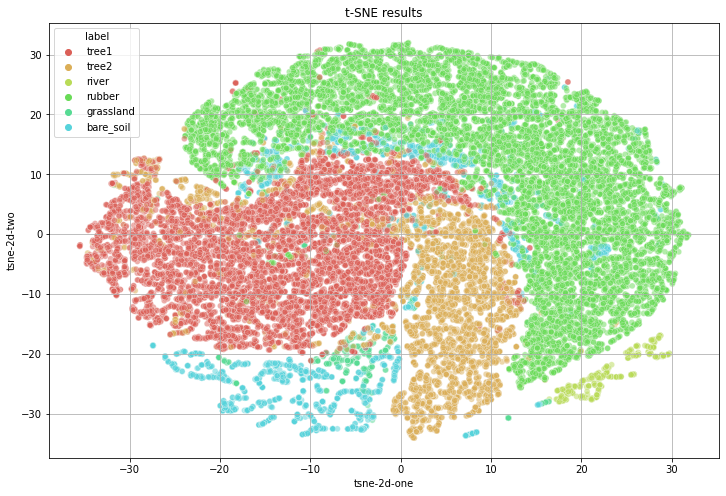

In [336]:
#Subsample dataset before running t-SNE
vc = df["label"].value_counts()

#Compute the weights based on the value counts
weights = {k: 1/v for k, v in vc.items()}
df_sample = df.sample(n=int(df.shape[0]/3), weights=df["label"].map(weights))
data_sub, labels_sub = df_sample.iloc[:,:-1].values, df_sample.iloc[:,-1].values

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=500, random_state=0)
data_tsne = tsne.fit_transform(data_sub)

#Add results to dataframe
df_sample['tsne-2d-one'] = data_tsne[:,0]
df_sample['tsne-2d-two'] = data_tsne[:,1]

plt.figure(figsize=(12,8))
plt.title("t-SNE results")
plt.grid()
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df_sample,
    legend="full",
    alpha=0.5
)

<AxesSubplot:title={'center':'PCA results'}, xlabel='pca-one', ylabel='pca-two'>

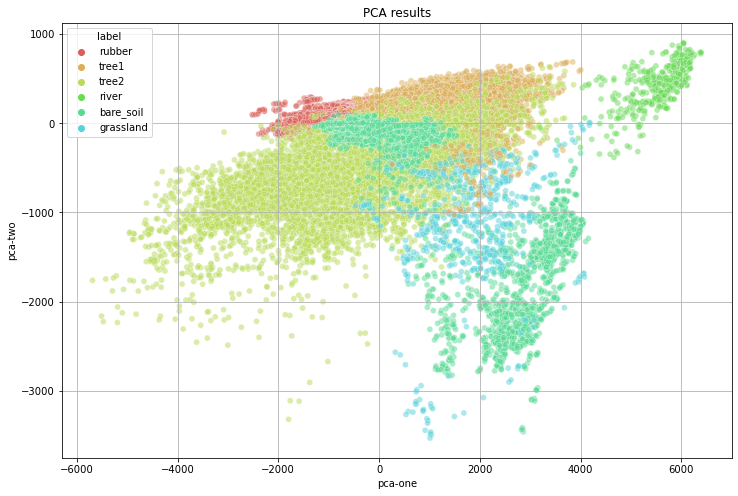

In [353]:
# Perform PCA 
dfn, principalComponents = perform_pca(df)

plt.figure(figsize=(12,8))
plt.title("PCA results")
plt.grid()
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=dfn,
    legend="full",
    alpha=0.5
)

In [20]:
# Perform grid search
# Define the parameter grid to search over
param_grid = {
    'max_depth': [4], #4
    'n_estimators': [1200], #1200
    'learning_rate': [0.2, 0.25], #0.1
}

# Create the XGBClassifier object
xgb = XGBClassifier()

# Define the scoring metric
scorer = make_scorer(f1_score, average='macro')

# Create the grid search object
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                        #    cv=10,
                           scoring=scorer,
                           verbose=2,
                           n_jobs=-1,
                           error_score='raise')


X, y = df.iloc[:,:-1].values, df.iloc[:,-1].values

categories = df['label'].unique()
mapping_dict = {}
unique_id = 1
for category in categories:
    mapping_dict[category] = unique_id
    unique_id += 1

#Create a list of unique values in the numpy array
unique_vals = np.unique(y)
#Create an array of mapped values using the mapping dictionary
mapped_vals = np.array([mapping_dict[x] for x in unique_vals])

#Use the numpy take function to apply the mapping to the original array
Y = np.take(mapped_vals, np.searchsorted(unique_vals, y))
Y = Y-1

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by grid search
print(f"Best hyperparameters: {grid_search.best_params_}")
# Evaluate the best model on the test data
best_model = grid_search.best_estimator_

# First predict at the test set
print("Getting the stats for the test set:")
y_pred = best_model.predict(X_test)
f1_macro = np.round(f1_score(y_test, y_pred, average='macro'), 3)
print(f"F1 Macro: {f1_macro}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .learning_rate=0.25, max_depth=4, n_estimators=1200; total time= 4.6min
[CV] END .learning_rate=0.25, max_depth=4, n_estimators=1200; total time= 4.7min
[CV] END .learning_rate=0.25, max_depth=4, n_estimators=1200; total time= 4.7min
[CV] END .learning_rate=0.25, max_depth=4, n_estimators=1200; total time= 4.7min
[CV] END .learning_rate=0.25, max_depth=4, n_estimators=1200; total time= 4.8min
[CV] END ..learning_rate=0.2, max_depth=4, n_estimators=1200; total time= 4.8min
[CV] END ..learning_rate=0.2, max_depth=4, n_estimators=1200; total time= 4.9min
[CV] END ..learning_rate=0.2, max_depth=4, n_estimators=1200; total time= 4.9min
[CV] END ..learning_rate=0.2, max_depth=4, n_estimators=1200; total time= 4.9min
[CV] END ..learning_rate=0.2, max_depth=4, n_estimators=1200; total time= 5.0min
Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 1200}
Getting the stats for the test set:
F1 Macro: 0

In [31]:
xgb = XGBClassifier(n_estimators=1200,
                            max_depth=4,
                            learning_rate = 0.2,
                            random_state=42, 
                            n_jobs=-1)

X, y = df.iloc[:,:-1].values, df.iloc[:,-1].values

categories = df['label'].unique()
mapping_dict = {}
unique_id = 1
for category in categories:
    mapping_dict[category] = unique_id
    unique_id += 1

#Create a list of unique values in the numpy array
unique_vals = np.unique(y)
#Create an array of mapped values using the mapping dictionary
mapped_vals = np.array([mapping_dict[x] for x in unique_vals])

#Use the numpy take function to apply the mapping to the original array
Y = np.take(mapped_vals, np.searchsorted(unique_vals, y))
Y = Y-1

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) #X

# Train model on training set
xgb.fit(X_train, y_train)

# Predict on test set
y_pred = xgb.predict(X_test)

# Calculate the F1 score with macro average
f1_macro = f1_score(y_test, y_pred, average='macro')

# Print the F1 score with macro average
print('F1 score (macro average):', f1_macro)

#Prediction part
path2predict = "./20230224T031729_mutliband.jp2"

with rasterio.open(path2predict) as src:
    values, profile = src.read(), src.meta.copy()
    img = np.moveaxis(values, 0, -1)
    vis = calculate_vi(img) 
    fsn = np.concatenate((img, vis), axis=2)
    fsn = fsn.reshape(-1, fsn.shape[2])
    arr = fsn[...,0]
    # Get the indices of non-zero elements
    nonzero_indices = np.nonzero(arr)
    # Get the indices of zero elements
    zero_indices = np.where(arr == 0)
    fsn = fsn[~np.all(fsn == 0, axis=1)]

df_pred = pd.DataFrame(fsn)
X_pred = df_pred.values

y_pred = xgb.predict(X_pred) 
y_pred = y_pred + 1

# Create empty array of zeros
arrn = np.zeros(arr.shape)
np.put(arrn, nonzero_indices, y_pred)

arrn = arrn.reshape((values.shape[1],values.shape[2]))
arrn = arrn.astype(np.int16)

# perform morphological opening with a 3x3 square structuring element

closed_arr = ndimage.grey_erosion(ndimage.grey_erosion(arrn, size=1), size=1)
opened_arr = ndimage.grey_erosion(ndimage.grey_dilation(closed_arr, size=3), size=3)

profile['count'] = 1
outpath = "./path2output/output2.tif"

with rasterio.open(outpath, 'w', **profile) as dst:
    dst.write(opened_arr, 1)

F1 score (macro average): 0.9909631536399447
